<a href="https://colab.research.google.com/github/KC3P0/NFL-Data/blob/main/Gridiron_Intelligence_2026_NFL_Analytics_with_Draft_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


"""
Introduction
------------
The Gridiron Intelligence analytics project presents a data-driven framework
designed to identify and address NFL team weaknesses through a simulated
2026 NFL Draft methodology. By quantifying game-losing factors from the 2025
season—such as turnovers, sacks, and defensive inefficiencies—the analysis
uses Expected Points Added (EPA) as the primary metric for translating
on-field deficiencies into position-specific needs for all 32 teams.

The methodology includes the calculation of refined positional need scores,
the application of a QB adjustment factor to avoid overweighting quarterback
deficiencies, and the execution of a 24-pick draft simulation using a
"Best Player Available within top needs" strategy.
"""


In [31]:
# Install and import necessary libraries
!pip install nflreadpy
import pandas as pd
import polars as pl
import re
import nflreadpy as nfl
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
pbp_data = nfl.load_pbp(seasons=2025)

In [33]:
prospect_data_text = """
1. Arvell Reese – Ohio State – LB
2. Fernando Mendoza – Indiana – QB
3. Jeremiyah Love – Notre Dame – RB
4. Spencer Fano – Utah – OT
5. David Bailey – Texas Tech – EDGE
6. Caleb Downs – Ohio State – S
7. Francis Mauigoa – Miami – OT
8. Rueben Bain Jr. – Miami – EDGE
9. Jordyn Tyson – Arizona State – WR
10. Sonny Styles – Ohio State – LB
11. Carnell Tate – Ohio State – WR
12. Kenyon Sadiq – Oregon – TE
13. Peter Woods – Clemson – DT
14. Keldric Faulk – Auburn – EDGE
15. Makai Lemon – USC – WR
16. Jermod McCoy – Tennessee – CB
17. Caleb Lomu – Utah – OT
18. Akheem Mesidor – Miami – EDGE
19. Kayden McDonald – Ohio State – DT
20. Mansoor Delane – LSU – CB
21. Ty Simpson – Alabama – QB
22. Avieon Terrell – Clemson – CB
23. Kadyn Proctor – Alabama – OT
24. Denzel Boston – Washington – WR
25. Cashius Howell – Texas A&M – EDGE
26. Zachariah Branch – Georgia – WR
27. CJ Allen – Georgia – LB
28. Chris Johnson – San Diego State – CB
29. Emmanuel Pregnon – Oregon – OG
30. Brandon Cisse – South Carolina – CB
31. Caleb Banks – Florida – DT
32. Olaivavega Ioane – Penn State – OG
33. Lee Hunter – Texas Tech – DT
34. Monroe Freeling – Georgia – OT
35. KC Concepcion – Texas A&M – WR
36. Jake Golday – Cincinnati – LB
37. Carson Beck – Miami – QB
38. Keionte Scott – Miami – CB
39. T.J. Parker – Clemson – EDGE
40. Colton Hood – Tennessee – CB
41. Blake Miller – Clemson – OT
42. Max Klare – Ohio State – TE
43. Chris Bell – Louisville – WR
44. Dillon Thieneman – Oregon – S
45. Anthony Hill Jr. – Texas – LB
46. R Mason Thomas – Oklahoma – EDGE
47. Caleb Tiernan – Northwestern – OT
48. Chris Brazzell II – Tennessee – WR
49. Emmanuel McNeil-Warren – Toledo – S
50. Joe Royer – Cincinnati – TE
51. Devin Moore – Florida – CB
52. Brian Parker II – Duke – OT
53. Germie Bernard – Alabama – WR
54. Zion Young – Missouri – EDGE
55. Davison Igbinosun – Ohio State – CB
56. Christen Miller – Georgia – DT
57. Deontae Lawson – Alabama – LB
58. Ja'Kobi Lane – USC – WR
59. Connor Lew – Auburn – C
60. Gracen Halton – Oklahoma – DT
61. Isaiah World – Oregon – OT
62. Antonio Williams – Clemson – WR
63. Darrell Jackson Jr. – Florida State – DT
64. Kyle Louis – Pittsburgh – LB
65. Dani Dennis-Sutton – Penn State – EDGE
66. Eli Stowers – Vanderbilt – TE
67. Billy Schrauth – Notre Dame – OG
68. A.J. Haulcy – LSU – S
69. Logan Jones – Iowa – C
70. Ar'Maj Reed-Adams – Texas A&M – OG
71. D'Angelo Ponds – Indiana – CB
72. Gennings Dunker – Iowa – OT
73. LT Overton – Alabama – EDGE
74. Keith Abney II – Arizona State – CB
75. Drew Shelton – Penn State – OT
76. Nicholas Singleton – Penn State – RB
77. Max Iheanachor – Arizona State – OT
78. Malik Muhammad – Texas – CB
79. Zakee Wheatley – Penn State – S
80. Gabe Jacas – Illinois – EDGE
81. Jake Slaughter – Florida – C
82. Dallen Bentley – Utah – TE
83. Kamari Ramsey – USC – S
84. Jack Endries – Texas – TE
85. Derrick Moore – Michigan – EDGE
86. Tim Keenan III – Alabama – DT
87. Jacob Rodriguez – Texas Tech – LB
88. Chandler Rivers – Duke – CB
89. Joshua Josephs – Tennessee – EDGE
90. Elijah Sarratt – Indiana – WR
91. Aiden Fisher – Indiana – LB
92. Trinidad Chambliss – Ole Miss – QB
93. Aamil Wagner – Notre Dame – OT
94. Skyler Gill-Howard – Texas Tech – DT
95. Romello Height – Texas Tech – EDGE
96. Kaytron Allen – Penn State – RB
97. Jaishawn Barham – Michigan – EDGE
98. Louis Moore – Indiana – S
99. Jalon Kilgore – South Carolina – S
100. Emmett Johnson – Nebraska – RB

Draft Order:
1. Las Vegas Raiders
2. New York Jets
3. Arizona Cardinals
4. Tennessee Titans
5. New York Giants
6. Cleveland Browns
7. Washington Commanders
8. New Orleans Saints
9. Kansas City Chiefs
10. Cincinnati Bengals
11. Miami Dolphins
12. Dallas Cowboys
13. Los Angeles Rams
14. Baltimore Ravens
15. Tampa Bay Buccaneers
16. New York Jets
17. Detroit Lions
18. Minnesota Vikings
19. Carolina Panthers
20. Dallas Cowboys
21. Pittsburgh Steelers
22. Los Angeles Chargers
23. Philadelphia Eagles
24. Cleveland Browns
25. Jacksonville Jaguars
26. Chicago Bears
27. Buffalo Bills
28. San Francisco 49ers
29. Houston Texans
"""


In [39]:
prospect_pattern = re.compile(r'^(\d+)\.\s*([^,]+?) – ([^–]+?) – (.+)$', re.MULTILINE)
prospect_matches = prospect_pattern.findall(prospect_data_text)
prospects_df = pd.DataFrame([{'Pick Number (Placeholder)': int(m[0]), 'Prospect Name': m[1].strip(), 'College': m[2].strip(), 'Position': m[3].strip()} for m in prospect_matches])

draft_order_pattern = re.compile(r'^(\d+)\.\s*(.+)$', re.MULTILINE)
# Extract the draft order section from prospect_data_text
draft_order_section_start = prospect_data_text.find('Draft Order:')
if draft_order_section_start != -1:
    draft_order_section_text = prospect_data_text[draft_order_section_start:]
else:
    draft_order_section_text = '' # Handle case where 'Draft Order:' is not found

draft_order_matches = draft_order_pattern.findall(draft_order_section_text)
draft_order_df = pd.DataFrame([{'Pick Number': int(m[0]), 'Team': m[1].strip()} for m in draft_order_matches])

In [35]:
# Calculate EPA Lost per team across various metrics [36-50]
offensive_epa_lost = pbp_data.group_by('posteam').agg(pl.sum('epa').alias('Offensive EPA')).with_columns((pl.col('Offensive EPA') * -1).alias('Offensive EPA Lost')).select('posteam', 'Offensive EPA Lost').rename({'posteam': 'Team'})
defensive_epa_lost = pbp_data.group_by('defteam').agg(pl.sum('epa').alias('Defensive EPA Lost')).rename({'defteam': 'Team'})
opponent_3rd_down_epa_lost = pbp_data.filter((pl.col('down') == 3) & (pl.col('yards_gained') >= pl.col('ydstogo'))).group_by('defteam').agg(pl.sum('epa').alias('Opponent 3rd Down Conversion EPA Lost')).rename({'defteam': 'Team'})
turnover_epa_lost = pbp_data.filter((pl.col('interception') == 1) | (pl.col('fumble_lost') == 1)).group_by('posteam').agg(pl.sum('epa').alias('Turnover EPA Lost')).rename({'posteam': 'Team'})
sack_epa_lost = pbp_data.filter(pl.col('sack') == 1).group_by('posteam').agg(pl.sum('epa').alias('Sack EPA Lost')).rename({'posteam': 'Team'})
penalty_epa_lost = pbp_data.filter(pl.col('penalty_yards') > 0).group_by('posteam').agg(pl.sum('epa').alias('Penalty EPA Lost')).rename({'posteam': 'Team'})

# Merge into comprehensive Game-Losing Factors DataFrame [30, 51, 52]
all_teams_df = pbp_data.select(pl.col('posteam').unique()).rename({'posteam': 'Team'})
game_losing_factors_epa = all_teams_df.join(turnover_epa_lost, on='Team', how='left').join(sack_epa_lost, on='Team', how='left').join(penalty_epa_lost, on='Team', how='left').join(offensive_epa_lost, on='Team', how='left').join(defensive_epa_lost, on='Team', how='left').join(opponent_3rd_down_epa_lost, on='Team', how='left').fill_null(0)

In [36]:
# Refined Factor-to-Position Mapping [53, 55-57, 61]
factor_to_positions = {
    'Turnover EPA Lost': ['QB', 'RB', 'WR', 'TE'],
    'Sack EPA Lost': ['OT', 'OG', 'C', 'QB', 'EDGE', 'DT'], # DT added for balance
    'Penalty EPA Lost': ['DT', 'DB', 'C', 'LB', 'EDGE'], # OT/OG removed for balance
    'Offensive EPA Lost': ['QB', 'WR', 'RB', 'TE', 'OT', 'OG', 'C'],
    'Defensive EPA Lost': ['CB', 'S', 'LB', 'DT', 'EDGE'],
    'Opponent 3rd Down Conversion EPA Lost': ['CB', 'S', 'LB', 'DT', 'EDGE']
}

relevant_positions = list(set([pos for positions in factor_to_positions.values() for pos in positions]))
team_need_scores = game_losing_factors_epa.clone()

for pos in relevant_positions:
    team_need_scores = team_need_scores.with_columns(pl.lit(0.0).alias(f'{pos}_Need_Score'))

for factor, positions in factor_to_positions.items():
    for pos in positions:
        if factor in ['Turnover EPA Lost', 'Sack EPA Lost']:
            team_need_scores = team_need_scores.with_columns((pl.col(f'{pos}_Need_Score') + (pl.col(factor) * -1)).alias(f'{pos}_Need_Score'))
        else:
            team_need_scores = team_need_scores.with_columns((pl.col(f'{pos}_Need_Score') + pl.col(factor).clip(lower_bound=0)).alias(f'{pos}_Need_Score'))


In [37]:
# Final QB Adjustment and Filtering [58, 60, 62]
team_need_scores = team_need_scores.with_columns((pl.col('QB_Need_Score') / 1.5).alias('QB_Need_Score'))
team_need_scores_filtered = team_need_scores.filter(pl.col('Team').is_not_null())

In [40]:
simulated_draft_results = []
available_prospects_df = pl.DataFrame(prospects_df)
team_name_mapping = {'Las Vegas Raiders': 'LV', 'New York Jets': 'NYJ', 'Arizona Cardinals': 'ARI', 'Tennessee Titans': 'TEN', 'New York Giants': 'NYG', 'Cleveland Browns': 'CLE', 'Washington Commanders': 'WAS', 'New Orleans Saints': 'NO', 'Kansas City Chiefs': 'KC', 'Cincinnati Bengals': 'CIN', 'Miami Dolphins': 'MIA', 'Dallas Cowboys': 'DAL', 'Los Angeles Rams': 'LA', 'Baltimore Ravens': 'BAL', 'Tampa Bay Buccaneers': 'TB', 'Detroit Lions': 'DET', 'Minnesota Vikings': 'MIN', 'Carolina Panthers': 'CAR', 'Pittsburgh Steelers': 'PIT', 'Los Angeles Chargers': 'LAC', 'Philadelphia Eagles': 'PHI', 'Jacksonville Jaguars': 'JAX', 'Chicago Bears': 'CHI', 'Buffalo Bills': 'BUF', 'San Francisco 49ers': 'SF', 'Houston Texans': 'HOU'}

draft_order_pl = pl.DataFrame(draft_order_df).with_columns(pl.col('Team').replace_strict(team_name_mapping).alias('Abbreviated_Team'))

for pick_num, full_team, abbr_team in draft_order_pl.select(['Pick Number', 'Team', 'Abbreviated_Team']).iter_rows():
    team_row = team_need_scores_filtered.filter(pl.col('Team') == abbr_team)
    if team_row.is_empty(): continue

    # Identify top 5 needs [66-68]
    needs = sorted([(team_row.select(pl.col(f'{p}_Need_Score')).item(), p) for p in relevant_positions], reverse=True)[:5]
    top_5_needs = [n[1] for n in needs]

    # Select Best Player Available matching needs [69-71]
    matches = available_prospects_df.filter(pl.col('Position').is_in(top_5_needs))
    if not matches.is_empty():
        selected = matches.sort('Pick Number (Placeholder)').head(1)
        simulated_draft_results.append({'Pick': pick_num, 'Team': full_team, 'Prospect Name': selected['Prospect Name'].item(), 'Position': selected['Position'].item()})
        available_prospects_df = available_prospects_df.filter(pl.col('Pick Number (Placeholder)') != selected['Pick Number (Placeholder)'].item())

simulated_draft_df = pl.DataFrame(simulated_draft_results)

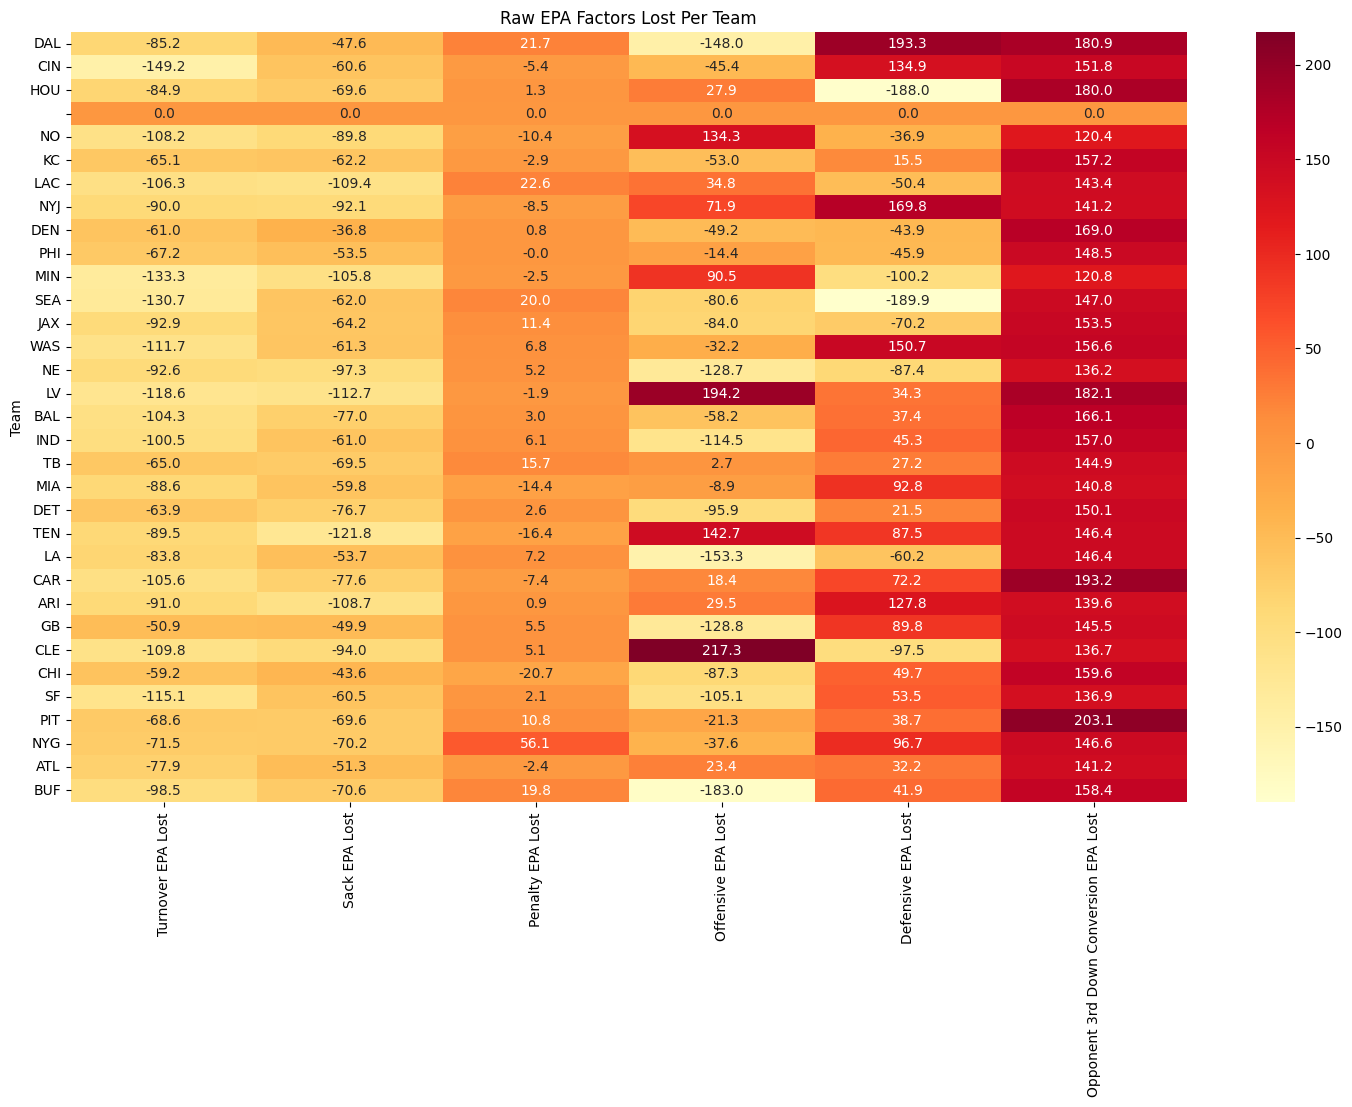

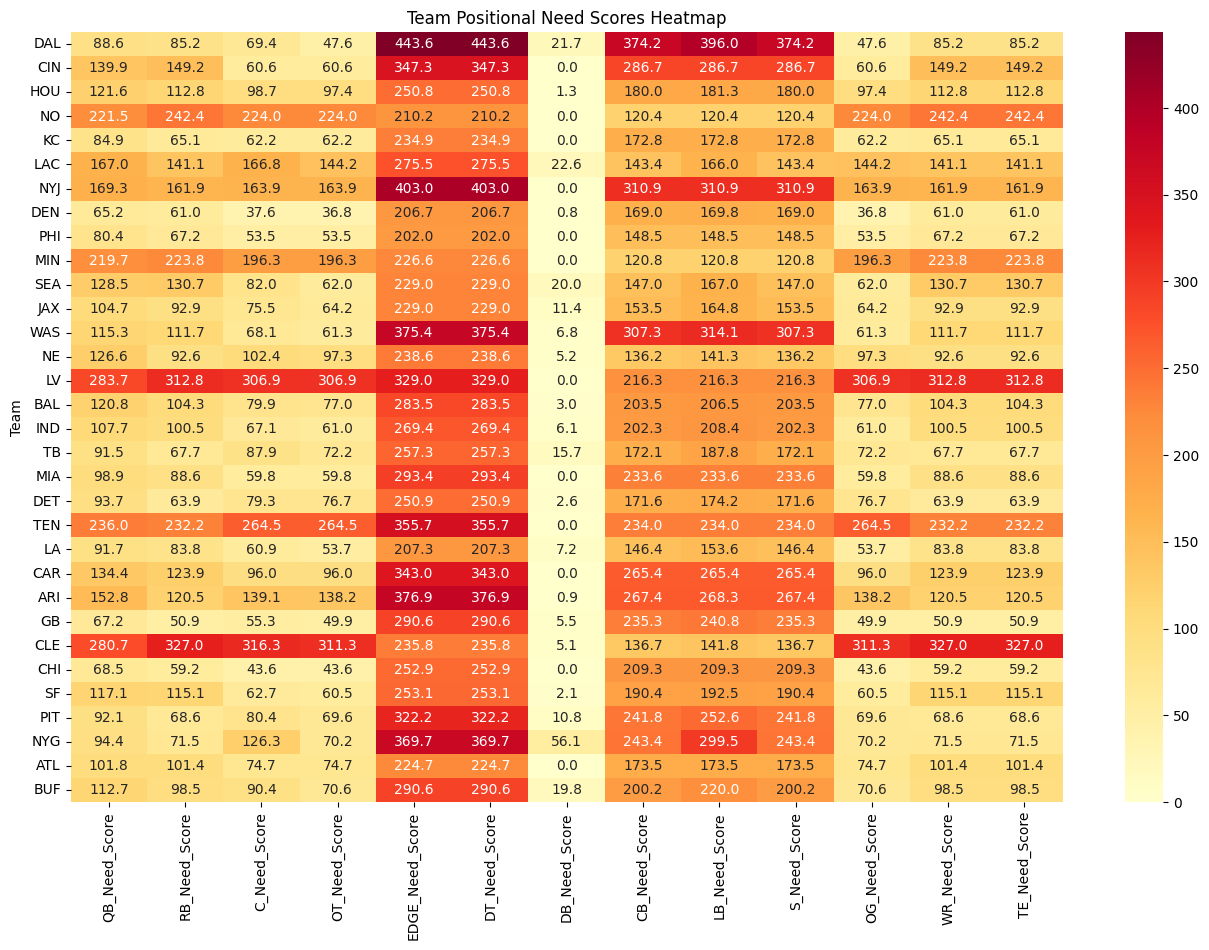

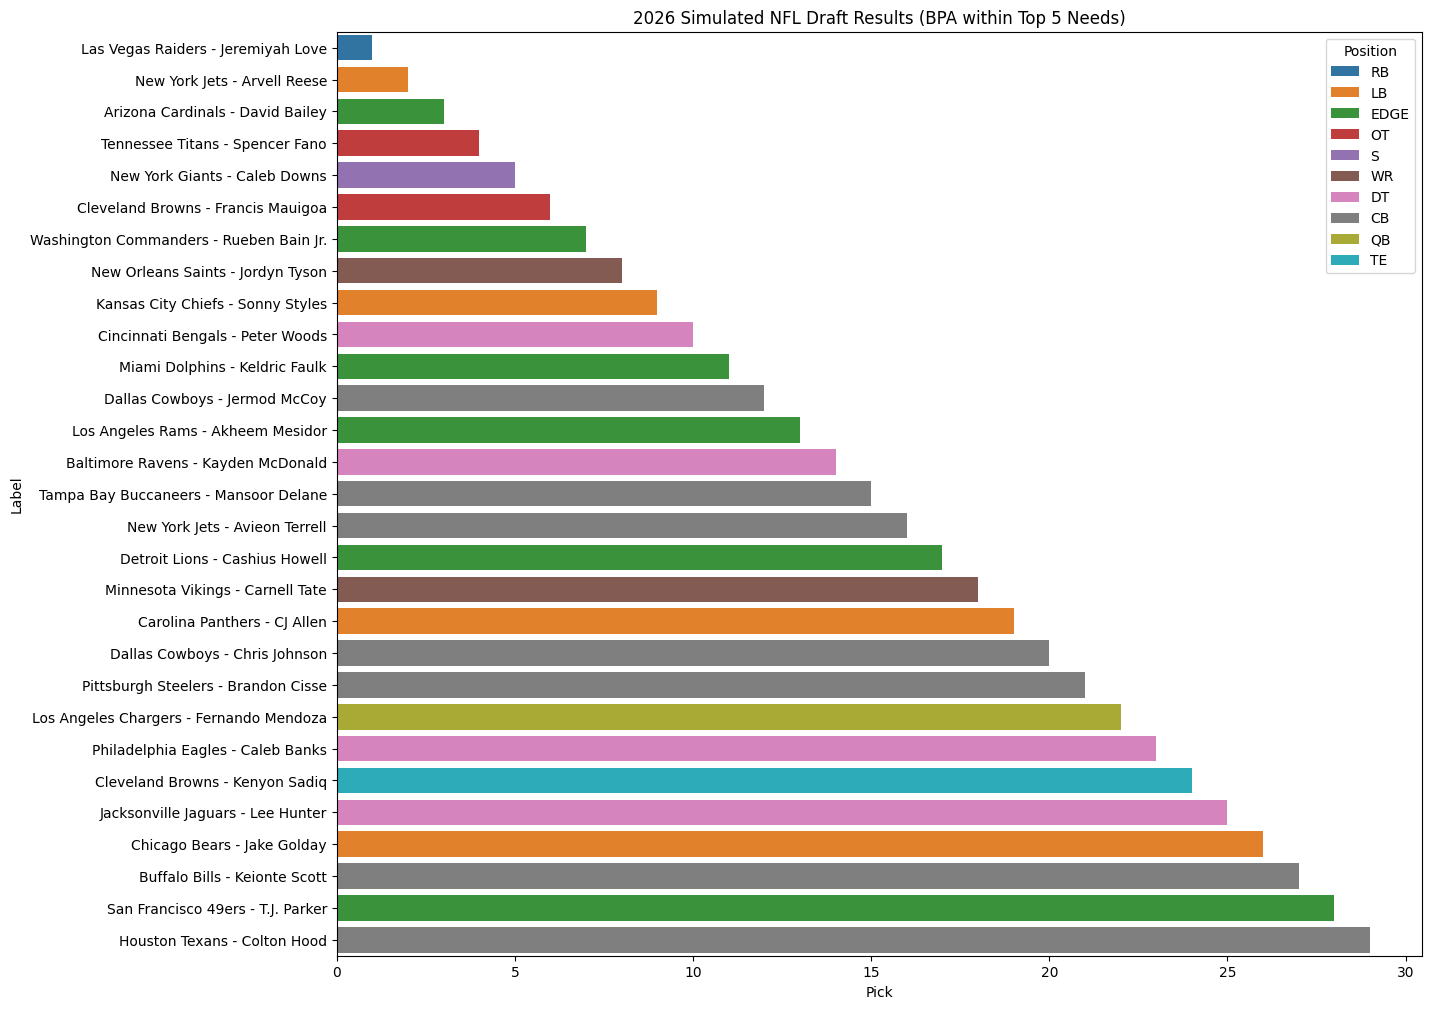

In [41]:
# A. Raw EPA Factors Heatmap: Shows where teams are losing value [72, 77, 78]
epa_factors_pd = game_losing_factors_epa.select(['Team', 'Turnover EPA Lost', 'Sack EPA Lost', 'Penalty EPA Lost', 'Offensive EPA Lost', 'Defensive EPA Lost', 'Opponent 3rd Down Conversion EPA Lost']).to_pandas().set_index('Team')
plt.figure(figsize=(18, 10))
sns.heatmap(epa_factors_pd, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title('Raw EPA Factors Lost Per Team')
plt.show()

# B. Positional Need Score Heatmap: Highlights league-wide and team-specific weaknesses [56, 74, 79-81]
heatmap_pd = team_need_scores_filtered.to_pandas().set_index('Team')[[f'{p}_Need_Score' for p in relevant_positions]]
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_pd, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title('Team Positional Need Scores Heatmap')
plt.show()

# C. Draft Results Summary: Displays how teams addressed their deficiencies [82-84]
sim_pd = simulated_draft_df.to_pandas()
sim_pd['Label'] = sim_pd['Team'] + ' - ' + sim_pd['Prospect Name']
plt.figure(figsize=(14, 12))
sns.barplot(x='Pick', y='Label', hue='Position', data=sim_pd, dodge=False)
plt.title('2026 Simulated NFL Draft Results (BPA within Top 5 Needs)')
plt.show()


"""
Closing Summary
---------------
This analysis provides a strong foundation for strategic NFL roster
construction by moving beyond traditional scouting to quantify and prioritize
team needs effectively. A key result of the approach was the calibrated QB
prioritization, which prevented QB metrics from overshadowing other critical
positions. This allowed teams to more accurately address deficiencies along
the defensive front seven (EDGE and DT) and the offensive line (OT and OG)
when quarterback upgrades were not the most immediate concern.

The draft simulation demonstrated that integrating EPA-based game-losing
factors with Best Player Available logic enables teams to balance talent
acquisition with targeted need fulfillment. This combined method offers a
clear, data-driven perspective for evaluating draft classes, optimizing
decision-making, and addressing roster weaknesses efficiently.
"""




"""
Data Dictionary: Variable Meanings
----------------------------------

Core DataFrames
---------------

pbp_data:
    Granular 2025 NFL play-by-play dataset containing EPA, turnovers,
    sacks, penalties, and third-down outcomes.

prospects_df:
    Structured dataset of the top 75 prospects for the 2026 NFL Draft,
    including player names, colleges, and specific positions (e.g., EDGE, DT, TE).

draft_order_df:
    Confirmed order for the first 24 selections in the 2026 NFL Draft.

game_losing_factors_epa:
    Merged dataset quantifying each team's total EPA lost due to specific
    performance deficiencies.

team_need_scores_filtered:
    Final dataset containing refined positional need scores for 13 positions
    across all 32 teams after null-value filtering and scaling adjustments.

simulated_draft_df:
    Output of the 24-pick draft simulation, recording pick number, team,
    prospect name, and position selected.


Analytical Logic & Parameters
-----------------------------

factor_to_positions:
    Dictionary mapping EPA-loss factors to the positions associated with them.
    Example: "Sack EPA Lost" → ["OT", "QB"].

relevant_positions:
    List of all unique positions derived from the mapping dictionary, used
    when calculating positional need scores.

qb_adjustment_factor:
    Constant value (1.5) used to scale down raw QB need scores to prevent
    overinflation of QB needs relative to other positions.

top_n_needs:
    Parameter (value: 5) defining how many of a team's highest positional
    needs are considered when selecting the Best Player Available during
    simulation.

Needs Addressed Count:
    Metric used for evaluating the draft's effectiveness by measuring how
    many of a team's top 5 needs the simulation filled.
"""
